In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb


import torchvision

In [2]:
import itertools

class CustomLoss():
    def __init__(self):
        numbers = list(range(10))  # Represents numbers 0 to 9
        all_sets = torch.tensor(list(itertools.product(numbers, repeat=4))).detach()
        self.all_sums = [[] for _ in range(37)]
        for vector in all_sets:
            sm = vector.sum()
            self.all_sums[sm].append(vector)

        for i in range(37):
            # print(i, self.all_sums[0].shape)
            self.all_sums[i] = torch.stack(self.all_sums[i], dim=0)

    def calculate(self, logits, all_sum):
        # logits are b x 10 x 4
        probability = logits.softmax(dim=1)
        loss = 0.0
        # print(self.all_sums)
        # construct b x number
        for logit,one_sum  in zip(probability, all_sum):
            # print(logit,one_sum)
            all_prob = logit[self.all_sums[one_sum], torch.arange(4)]
            loss += all_prob.prod(-1).sum()
            # for vector4 in self.all_sums[one_sum]:

            #     x = logit[vector4, torch.arange(4)].prod(-1)
            #     print(logit[vector4, torch.arange(4)], vector4, logit[vector4, torch.arange(4)].prod(-1))
            #     loss += x

            # print(loss)
        loss = loss/all_sum.shape[0]
        return -torch.log(loss)
ls = CustomLoss()
logits  = torch.randn(500, 10, 4)
logits = torch.tensor([[[-0.0728,  0.0030, -0.0291,  0.0562],
        [ 0.0309, -0.0518, -0.0976, -0.0505],
        [ 0.0500, -0.1388, -0.1307,  0.0319],
        [-0.0719,  0.0126, -0.1199,  0.0309],
        [ 0.0208,  0.0994,  0.0255, -0.0431],
        [ 0.0839,  0.0313, -0.0417, -0.0018],
        [-0.0264, -0.0191,  0.0083, -0.1392],
        [-0.0471,  0.0610,  0.0044, -0.0841],
        [-0.1376,  0.0919, -0.0559,  0.0820],
        [ 0.0675,  0.0073,  0.1444,  0.0374]]])
print(logits.softmax(dim=1))
all_sum = torch.tensor([20])
ls.calculate(logits, all_sum)

tensor([[[0.0937, 0.0991, 0.0997, 0.1064],
         [0.1040, 0.0938, 0.0931, 0.0956],
         [0.1060, 0.0860, 0.0901, 0.1039],
         [0.0938, 0.1001, 0.0911, 0.1037],
         [0.1029, 0.1091, 0.1053, 0.0963],
         [0.1096, 0.1020, 0.0985, 0.1004],
         [0.0982, 0.0969, 0.1035, 0.0875],
         [0.0962, 0.1050, 0.1031, 0.0925],
         [0.0878, 0.1083, 0.0971, 0.1092],
         [0.1078, 0.0995, 0.1186, 0.1044]]])


tensor(2.7514)

In [5]:
class MyData(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32) / 256, self.label[idx]

    def __len__(self):
        return len(self.label)

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13015008378839818,), (0.30690425774764835,)),
    # transforms.Pad(padding=(0, 8,0,8)),
    #  transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.RandomResizedCrop((40, 20), scale=(0.7, 0.9), ratio=(0.9, 1.1)),   
])


transform_synth = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.13015008378839818,), (0.30690425774764835,)),
    # transforms.Pad(padding=(0, 8,0,8)),
    #  transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.RandomResizedCrop((40, 20), scale=(0.7, 0.9), ratio=(0.9, 1.1)),   
])
trainset = torchvision.datasets.MNIST(
    root='./data',  # Directory where data will be stored
    train=True,     # Get the training set
    download=True,  # Download the dataset if it's not already present
    transform=transform  # Apply the defined transformations
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,  # Get the test set
    download=True,
    transform=transform)
    
class SyntheticData(torch.utils.data.Dataset):
    def __init__(self, data, label, transform = transform):
        self.data = data
        self.label = label
        self.transform = transform

    def __getitem__(self, idx):
        length = self.__len__()
        index = torch.randint(0, length, (4,),)
        # print(index, length)
        final_img = []
        final_label = []

        for i in range(4):
            # print(self.data[index[i]].shape,)
            final_img.append(self.transform(self.data[index[i]]))
            final_label.append(self.label[index[i]])
            # print(final_img[-1].shape)
        

        return torch.cat(final_img, -1), torch.stack(final_label, -1)

    def __len__(self):
        return len(self.label)

In [ ]:
## Synthetic dataset generation

In [6]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

def randomly_fit_images(images, canvas_height, canvas_width):
    """
    Randomly fits a list of images onto a blank canvas without intersection.

    Args:
        images (list of torch.Tensor): A list of image tensors (C, H, W).
        canvas_height (int): The height of the canvas.
        canvas_width (int): The width of the canvas.

    Returns:
        torch.Tensor: The canvas tensor with the images placed.
    """
    num_images = len(images)
    image_height = images[0].shape[-2]
    image_width = images[0].shape[-1]
    channels = images[0].shape[-3]

    # Create a blank canvas
    canvas = torch.zeros(channels, canvas_height, canvas_width)

    # Keep track of placed regions to avoid intersections
    occupied_regions = []

    for img in images:
        placed = False
        attempts = 0
        max_attempts = 100  # To prevent infinite loops if no space is found

        while not placed and attempts < max_attempts:
            # Generate random top-left corner coordinates for placement
            max_x = canvas_width - image_width
            if max_x < 0:  # Handle case where image is wider than canvas
                break
            random_x = torch.randint(0, max_x + 1, (1,)).item()

            start_x = random_x
            end_x = start_x + image_width

            # Check for intersection with already placed images
            intersects = False
            for region_start, region_end in occupied_regions:
                if not (end_x <= region_start or start_x >= region_end):
                    intersects = True
                    break

            if not intersects:
                # Place the image onto the canvas
                canvas[:, :, start_x:end_x] = img
                # Add the current image's region to the occupied regions
                occupied_regions.append((start_x, end_x))
                placed = True
            attempts += 1

        if not placed:
            print(f"Warning: Could not place an image after {max_attempts} attempts.")

    return canvas, occupied_regions


class SyntheticDataset10000(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, self.targets[idx]

    def __len__(self):
        return len(self.targets)


def create_synthetic_dataset():
    # Define the dimensions
    image_height = 40
    image_width = 20
    num_images_per_tuple = 4
    canvas_height = 40
    canvas_width = 120
    num_tuples = 50000

    transform_synth = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.RandomResizedCrop((40, 20), scale=(0.7, 0.9), ratio=(0.9, 1.1)),   
    ])

    data = []
    targets = []

    for i in range(num_tuples):
        # Create 4 random images
        indices = torch.randperm(len(testset))[:num_images_per_tuple]
        images = [transform_synth(testset.data[idx].numpy()) for idx in indices] # Get images and normalize

        canvas, regions = randomly_fit_images((images), canvas_height, canvas_width)

        canvas = torch.cat([canvas, torch.zeros(1, 40,40)], dim=-1)
        regions = np.array(regions)[:,0].argsort()
        label = testset.targets[indices][regions]

        if label.shape[0] == 4:
            data.append(canvas)
            targets.append(label)
        # print(canvas.shape, label.shape)

    tr = transforms.Compose([
    # transforms.Normalize((0.13015008378839818,), (0.30690425774764835,)),
    ])

    ds = SyntheticDataset10000(torch.stack(data), torch.stack(targets), transform=None)

    return ds
ds = create_synthetic_dataset()
torch.save(ds, './dataset50ka.pth')


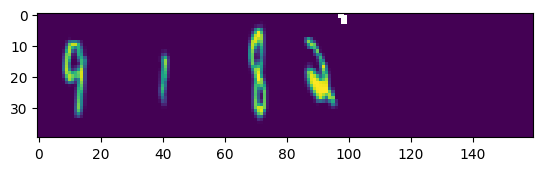

In [104]:
plt.imshow(ds.data[43454][0])

torch.Size([1, 40, 20])
torch.Size([1, 40, 20])
torch.Size([1, 40, 20])
torch.Size([1, 40, 20])
torch.Size([1, 40, 20])
torch.Size([1, 40, 20])
torch.Size([1, 40, 20])
torch.Size([1, 40, 20])
torch.Size([1, 40, 20])
torch.Size([1, 40, 20])


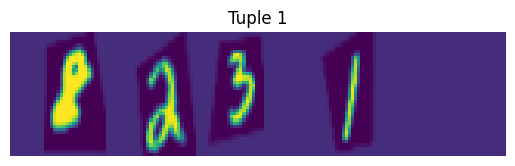

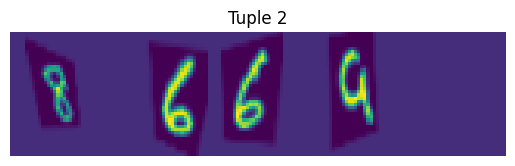

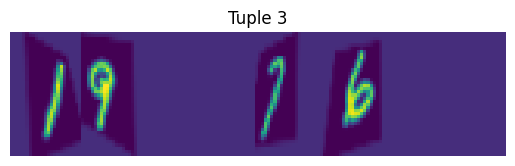

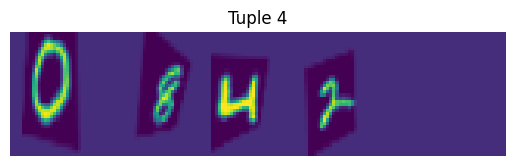

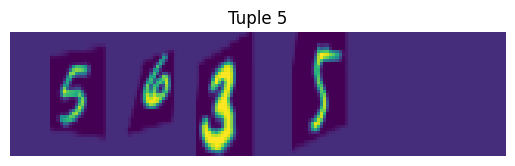

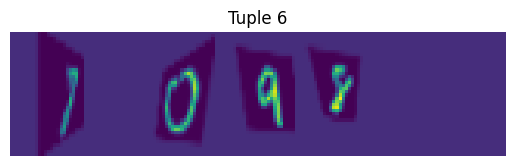

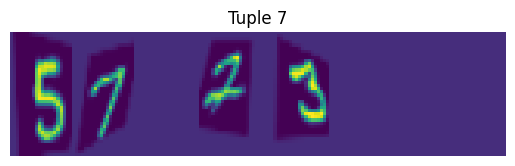

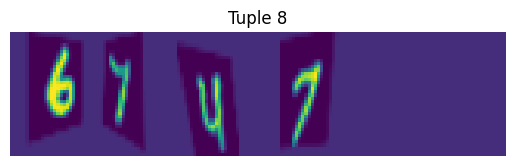

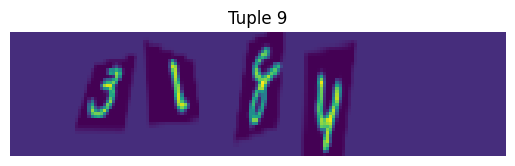

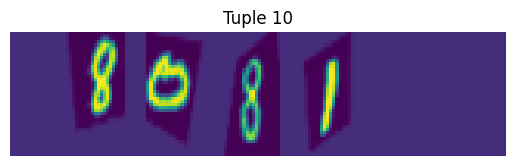

In [63]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

def randomly_fit_images(images, canvas_height, canvas_width):
    """
    Randomly fits a list of images onto a blank canvas without intersection.

    Args:
        images (list of torch.Tensor): A list of image tensors (C, H, W).
        canvas_height (int): The height of the canvas.
        canvas_width (int): The width of the canvas.

    Returns:
        torch.Tensor: The canvas tensor with the images placed.
    """
    num_images = len(images)
    image_height = images[0].shape[-2]
    image_width = images[0].shape[-1]
    channels = images[0].shape[-3]

    # Create a blank canvas
    canvas = torch.zeros(channels, canvas_height, canvas_width)

    # Keep track of placed regions to avoid intersections
    occupied_regions = []

    for img in images:
        placed = False
        attempts = 0
        max_attempts = 100  # To prevent infinite loops if no space is found

        while not placed and attempts < max_attempts:
            # Generate random top-left corner coordinates for placement
            max_x = canvas_width - image_width
            if max_x < 0:  # Handle case where image is wider than canvas
                break
            random_x = torch.randint(0, max_x + 1, (1,)).item()

            start_x = random_x
            end_x = start_x + image_width

            # Check for intersection with already placed images
            intersects = False
            for region_start, region_end in occupied_regions:
                if not (end_x <= region_start or start_x >= region_end):
                    intersects = True
                    break

            if not intersects:
                # Place the image onto the canvas
                canvas[:, :, start_x:end_x] = img
                # Add the current image's region to the occupied regions
                occupied_regions.append((start_x, end_x))
                placed = True
            attempts += 1

        if not placed:
            print(f"Warning: Could not place an image after {max_attempts} attempts.")

    return canvas

if __name__ == "__main__":
    # Define the dimensions
    image_height = 40
    image_width = 20
    num_images_per_tuple = 4
    canvas_height = 40
    canvas_width = 120
    num_tuples = 10

    # Define transformations
    # transform = transforms.ToTensor()
    # testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    for i in range(num_tuples):
        # Create 4 random images
        indices = torch.randperm(len(testset))[:num_images_per_tuple]
        images = [transform(testset.data[idx].numpy()) for idx in indices] # Get images and normalize
        print(images[0].shape)
        # Fit images onto the canvas
        canvas = randomly_fit_images((images), canvas_height, canvas_width)

        # Plot the canvas
        plt.figure()
        plt.imshow(torch.cat([canvas.permute(1, 2, 0), torch.zeros(canvas_height, 40, 1)], dim=1))
        plt.title(f"Tuple {i+1}")
        plt.axis('off')  # Turn off axis labels and ticks

    plt.show()

tensor([[7, 3, 1, 5],
        [3, 5, 2, 8],
        [3, 5, 2, 7],
        ...,
        [5, 3, 8, 2],
        [3, 5, 2, 7],
        [3, 5, 2, 9]], device='cuda:0')
tensor([7, 3, 1, 5], device='cuda:0')
tensor([3, 5, 2, 8], device='cuda:0')
tensor([3, 5, 2, 7], device='cuda:0')
tensor([3, 5, 8, 2], device='cuda:0')
tensor([3, 5, 7, 2], device='cuda:0')
tensor([3, 5, 7, 2], device='cuda:0')
tensor([3, 5, 1, 7], device='cuda:0')
tensor([3, 2, 5, 7], device='cuda:0')
tensor([3, 5, 2, 7], device='cuda:0')
tensor([3, 5, 2, 7], device='cuda:0')


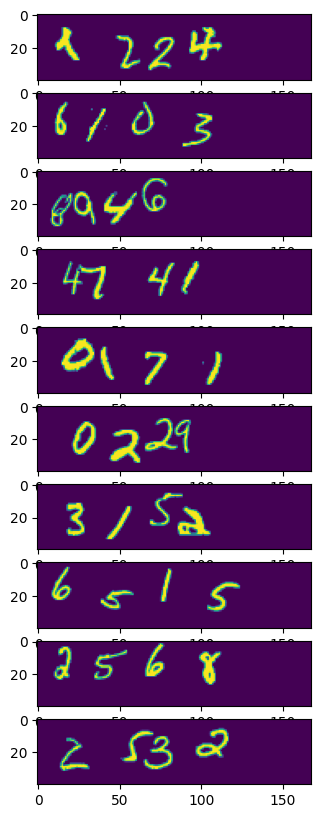

In [130]:
import matplotlib.pyplot as plt
print(outputs.topk(4)[1])
_, ax = plt.subplots(10,1, figsize=(10,10))

for i in range(10):
    # images[i][0::40] = 255
    ax[i].imshow(images[i].cpu())
    print(outputs.topk(4)[1][i])